# Подзапросы

**Подзапросы** в SQL — это мощный инструмент, позволяющий выполнять сложные запросы, в которых результат одного запроса используется в качестве условия или данных для другого запроса. Подзапросы могут использоваться в различных частях основного SQL-запроса, включая конструкции `SELECT`, `FROM`, `WHERE`, и даже в `HAVING` и `INSERT`. Разберем несколько случаев, когда стоит использовать подзапрос.

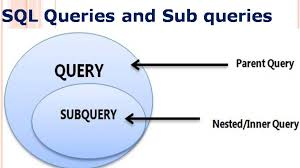

### 1. Условия выборки на основе вычисленных значений

Подзапросы позволяют фильтровать записи основной таблицы на основе агрегированных значений, вычисленных из той же таблицы или из связанных таблиц. Например, можно найти номера, цена которых выше средней по всем номерам.

    SELECT room_number, type_name, price_per_night
    FROM rooms
    WHERE price_per_night > (SELECT AVG(price_per_night) as mean_price FROM rooms)

### 2. Извлечение данных, которые должны соответствовать результатам другого запроса

Выборка данных, основанная на соответствии или различии с данными, полученными из другого запроса. Например, можно выбрать все бронирования, которые стоили больше средней стоимости заказа.

    SELECT booking_id, renter_id, room_number, check_in_date, check_out_date
    FROM bookings
    WHERE booking_id IN (
		SELECT booking_id
		FROM payments
		WHERE amount_paid > (SELECT AVG(amount_paid) FROM payments)
	)
    
    
### 3. Использование результата подзапроса в качестве источника данных

Подзапросы могут использоваться в FROM-секции для создания временной таблицы, которая затем используется для дальнейшего анализа или как часть более крупного запроса. Это позволяет выполнять сложные агрегации и анализы, которые были бы сложны или невозможны с использованием только основных таблиц. Выберем платежи, которые были в свой день самыми дорогими и самыми дешевыми

    SELECT payment_date, payment_id, amount_paid
    FROM (
        SELECT
		    payment_id,
            payment_date,
            amount_paid,
            MAX(amount_paid) OVER (PARTITION BY payment_date) as max_amount,
            MIN(amount_paid) OVER (PARTITION BY payment_date) as min_amount
        FROM payments
    ) as payments_agg
    WHERE amount_paid = max_amount OR amount_paid = min_amount
	ORDER BY payment_date
    
    
### 4. Сравнение с набором значений

В `WHERE` или `HAVING` секциях подзапросы часто используются для сравнения столбца с набором значений, полученным из другого запроса, с помощью операторов `IN`, `NOT IN`, `EXISTS`, `NOT EXISTS`. Выберем платежи, даты и суммы минимальных и максимальных платежей за всю историю нашей гостиницы.

    SELECT payment_date, amount_paid
    FROM payments
    WHERE amount_paid IN (
        SELECT MIN(amount_paid) FROM payments
		UNION SELECT MAX(amount_paid) FROM payments
    )
    
### 5. Использование результата подзапроса в условиях внутри SELECT

Мы можем использовать для этого подзапросы, которые возвращают число или столбец.

    SELECT
        room_number,
        price_per_night,
        CASE
            WHEN price_per_night > (SELECT AVG(price_per_night) FROM rooms) THEN 'Дорогой номер'
            ELSE 'Дешевый номер'
        END as room_price_category
    FROM rooms

### 6. Использование результата подзапроса в условии HAVING

Выведем сумму покупок клиентов за каждый день, но только в те дни, когда эта сумма была выше средней.

    SELECT payment_date, SUM(amount_paid) as income
    FROM payments
    GROUP BY payment_date
    HAVING SUM(amount_paid) > (
        SELECT AVG(income) FROM (
            SELECT
                SUM(amount_paid) as income
            FROM payments
            GROUP BY payment_date
        ) income_agg
    )
    
    
## CTE. Оператор WITH

В предыдущем запросе дважды используется один и тот же запрос:

    SELECT SUM(amount_paid) as income
    FROM payments
    GROUP BY payment_date
    
И это довольно неудобно. Сделать код более читаемым мы можем, используя CTE.

**CTE (Common Table Expression)** — это временный набор результатов, который определяется в рамках выполнения SQL-запроса. CTE предоставляет способ разбить сложные запросы на более простые части, делая их более удобочитаемыми и упрощая отладку. CTE можно представить как временную таблицу, доступную только в рамках одного запроса, и она не сохраняется как структура данных в базе данных.

Преимущества использования CTE:
- Читаемость и поддерживаемость. CTE позволяет структурировать запросы более понятным образом, разделяя их на логические блоки.
- Рекурсивные запросы. С помощью рекурсивных CTE можно выполнять сложные рекурсивные операции, например, обход деревьев или иерархий.
- Повторное использование. Один и тот же CTE можно использовать несколько раз в рамках одного запроса, избегая дублирования кода.

Перепишем предыдущий запрос с использованием оператора `WITH`:

    WITH date_amount_sum as (
        SELECT payment_date, SUM(amount_paid) as income
        FROM payments
        GROUP BY payment_date
    )
    SELECT payment_date, income
    FROM date_amount_sum
    WHERE income > (
        SELECT AVG(income)
        FROM date_amount_sum
    )
    
Можно также создать несколько промежуточных таблиц в одном операторе `WITH`:

    WITH 
        date_amount_sum as (
            SELECT payment_date, SUM(amount_paid) as income
            FROM payments
            GROUP BY payment_date
        ),
        mean_income_agg as (SELECT AVG(income) as mean_income FROM date_amount_sum)
    SELECT payment_date, income
    FROM date_amount_sum
    WHERE income > (SELECT mean_income FROM mean_income_agg)
    


## Классификация подзапросов

1. По размерности возвращаемого результата:

    - Скалярный: 1 столбец, не более 1 строки.
    - Список значений: 1 столбец, сколько угодно строк.
    - Таблица: не меньше 1 столбца, сколько угодно строк.

2. По связи с внешним запросом:

    - Коррелированный (связанный) – использует в себе поля внешнего запроса.
    - Некоррелированный (несвязанный) – самостоятельный запрос, не использующий поля внешнего запроса.
    
    
### Коррелированный подзапрос

Выведем информацию по каждому номеру нашей гостиницы, присоединив информацию о последней зарегистрированной дате выезда из этого номера.

    SELECT
        r.room_number,
        r.price_per_night,
        (
            SELECT MAX(b.check_out_date)
            FROM bookings b
            WHERE r.room_number = b.room_number
        )
    FROM rooms r
    
Здесь `r` и `b` - это т.н. **альясы**, которые помогают сократить количество символов в запросе, но всё-таки различить таблицы, из которых мы делаем выборку.

# Объединение нескольких таблиц: `JOIN`

Очень часто для анализа данных нам не хватает одной таблицы, и мы хотим подтянуть к ней данные из других таблиц. Эти таблицы обычно связаны друг с другом каким-то из столбцов. В нашей БД, например, есть таблица оплат `payments` и таблица бронирований `bookings`. И там, и там есть колонка `booking_id`:

    SELECT * FROM payments
    
    SELECT * FROM bookings
    
    
Если мы хотим вывести информацию сразу и о платежах, и о бронировании, то нам нужно "сджойнить" эти таблицы:

    SELECT
        room_number,
        check_in_date,
        check_out_date,
        payment_date,
        amount_paid
    FROM
        payments
        JOIN bookings ON bookings.booking_id = payments.booking_id
        
Здесь мы объединям строки, которые совпадают по значению поля `booking_id`.

Если мы попробуем добавить в выборку поле, которое есть в обеих таблицах, мы получим ошибку, которая говорит о том, что СУБД не может определиться, из какой конкретно начальной таблицы брать это поле:

    SELECT
        booking_id,
        room_number,
        check_in_date,
        check_out_date,
        payment_date,
        amount_paid
    FROM
        payments
        JOIN bookings ON bookings.booking_id = payments.booking_id
        
        
Это происходит из-за того, что полный набор колонок джойна выглядит так, что в нем повторяются колонки, содержащиеся в обеих таблицах.

    SELECT
        *
    FROM
        payments
        JOIN bookings ON bookings.booking_id = payments.booking_id
        
        
Получается, нам нужно указать таблицу явно. В данном случае нам без разницы, из какой таблицы брать значение.

    SELECT
        bookings.booking_id,
        room_number,
        check_in_date,
        check_out_date,
        payment_date,
        amount_paid
    FROM
        payments
        JOIN bookings ON bookings.booking_id = payments.booking_id
        
        
Поскольку программисты - существа ленивые, и им лень писать длинные названия таблиц, были придуманы альясы и для таблиц. При использовании джойнов рекомендую всегда у каждого поля указывать альяс таблицы, из которой оно берется, поскольку так вашим коллегам (да и вам из будущего) будет легче понять, что происходит в запросе:

    SELECT
        b.booking_id,
        b.room_number,
        b.check_in_date,
        b.check_out_date,
        p.payment_date,
        p.amount_paid
    FROM
        payments p
        JOIN bookings b ON p.booking_id = b.booking_id     -- чаще принято явно указывать предикат джойна
        
        
Кстати говоря, можно джойнить больше двух таблиц за раз:

    SELECT
        b.booking_id,
        b.room_number,
        c.first_name,
        c.last_name,
        b.check_in_date,
        b.check_out_date,
        p.payment_date,
        p.amount_paid
    FROM
        payments p
        JOIN bookings b ON p.booking_id = b.booking_id
        JOIN clients c ON b.renter_id = c.id
        
А еще можно джойнить таблицы не только по равенству полей, но и по любому валидному предикату. Посмотрим, есть ли такие бронирования, которые оплатили уже во время или после заезда.

    SELECT
        b.booking_id,
        b.room_number,
        b.check_in_date,
        b.check_out_date,
        p.payment_date,
        p.amount_paid
    FROM
        payments p
        JOIN bookings b ON p.booking_id = b.booking_id AND p.payment_date >= b.check_in_date
        

# Виды джойнов

## Inner Join

Запросы, представленные выше, не будут выводить те данные из таблиц, для которых в других таблицах джойна не нашлось соответствие. Т.е. представим следующие таблицы:

- `t1`:

| date       | t1_value |
|------------|----------|
| 2024-01-01 | 'a'      |
| 2024-01-02 | 'b'      |
| 2024-01-03 | 'c'      |
| 2024-01-04 | 'd'      |
| 2024-01-05 | 'e'      |

- `t2`:

| date       | t2_value |
|------------|----------|
| 2024-01-01 | 10       |
| 2024-01-02 | 20       |
| 2024-01-03 | 30       |
| 2024-01-04 | 40       |
| 2024-01-06 | 60       |

Если мы сджойним их по условию равенства дат, то в результате получим 4 строки. Остальные строки в выборке участвовать не будут, поскольку встречаются только в одной из таблиц джойна.

    SELECT t1.date, t1.t1_value, t2.t2_value FROM t1 JOIN t2 ON t1.date = t2.date

| date       | t1_value | t2_value |
|------------|----------|----------|
| 2024-01-01 | 'a'      | 10       |
| 2024-01-02 | 'b'      | 20       |
| 2024-01-03 | 'c'      | 30       |
| 2024-01-04 | 'd'      | 40       |

Такой тип соединения таблиц называется Inner Join. В коде его можно писать как `INNER JOIN`, так и просто `JOIN` - inner применяется по умолчанию.

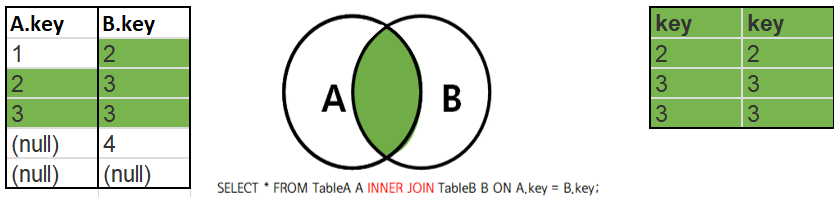

## Left Join

Или более полно - **Left Outer Join**. Этот вид соединения оставляет все строки левой (первой) таблицы, а из правой (второй) берет только те, которые подходят под условие джойна. Для тех строк левой таблицы, для которых не нашлось соответствия в правой, все значения правой таблицы будут `NULL`.

Приведем пример на тех же крохотных таблицах:

    SELECT t1.date, t1.t1_value, t2.t2_value FROM t1 LEFT JOIN t2 ON t1.date = t2.date

| date       | t1_value | t2_value |
|------------|----------|----------|
| 2024-01-01 | 'a'      | 10       |
| 2024-01-02 | 'b'      | 20       |
| 2024-01-03 | 'c'      | 30       |
| 2024-01-04 | 'd'      | 40       |
| 2024-01-05 | 'e'      | NULL     |

Стоит заметить, что порядок операндов при LEFT JOIN - важен. Если мы поменяем местами таблицы, то получим иной результат:

    SELECT t1.date, t1.t1_value, t2.t2_value FROM t2 LEFT JOIN t1 ON t1.date = t2.date

| date       | t1_value | t2_value |
|------------|----------|----------|
| 2024-01-01 | 'a'      | 10       |
| 2024-01-02 | 'b'      | 20       |
| 2024-01-03 | 'c'      | 30       |
| 2024-01-04 | 'd'      | 40       |
| 2024-01-06 | NULL     | 60       |

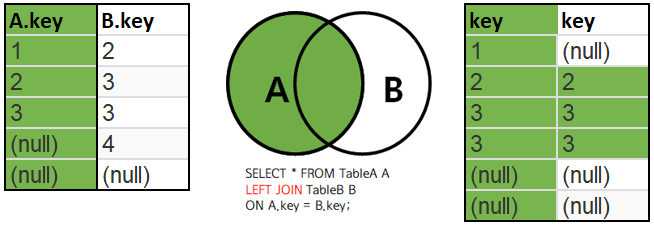

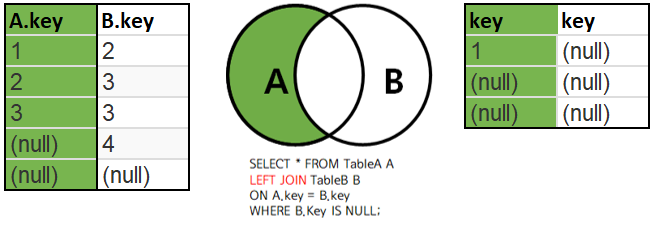

## Right Join

Это полная противоположность Left Join. Остаются все сроки правой таблицы, а в недостающих значениях столбцой левой таблицы появляются NULL. Результат `t1 RIGHT JOIN t2` будет эквивалентен `t2 LEFT JOIN t1` и наоборот. На практике RIGHT JOIN не используется практически никогда, если мы не хотим совершить диверсию в компании и запутать коллег.

### Пример LEFT JOIN

Не у всех бронирований есть оценки. А мы хотим посмотреть данные по бронированиям и прикрутить к ним рейтинг при его наличии.

    SELECT
        b.*,
        r.rating_value
    FROM bookings b LEFT JOIN ratings r ON b.booking_id = r.booking_id
    
    
## Full Outer Join
        

Это смесь Left и Right Join. В выборке остаются вообще все значения и из левой, и из правой таблиц. В обоих случаях те ячейки, в которые не получилось подставить значение из одной из таблиц, заполняются NULL.

    SELECT t1.date, t1.t1_value, t2.t2_value FROM t2 FULL JOIN t1 ON t1.date = t2.date

| date       | t1_value | t2_value |
|------------|----------|----------|
| 2024-01-01 | 'a'      | 10       |
| 2024-01-02 | 'b'      | 20       |
| 2024-01-03 | 'c'      | 30       |
| 2024-01-04 | 'd'      | 40       |
| 2024-01-05 | 'e'      | NULL     |
| 2024-01-06 | NULL     | 60       |


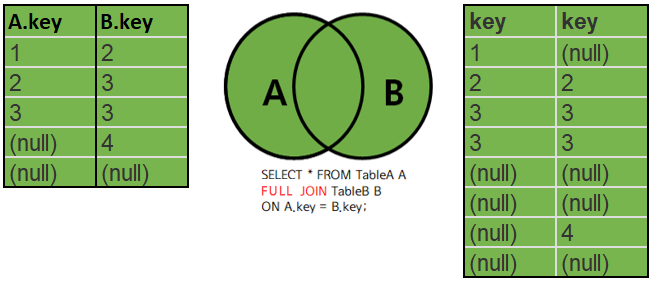

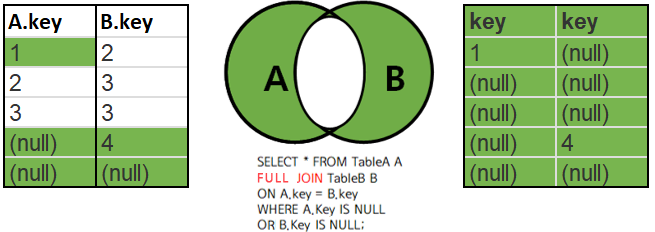

Допустим, мы хотим вывести список всех номеров и людей, живших когда-либо в них. Но в реальности у нас есть номера, в которых еще никто не успел пожить, а также есть гости, которые зарегистрировались у нас, но еще не успели сделать ни одного бронирования. И эти ситуации мы тоже хотим вывести в выборке.

    SELECT
        r.room_number,
        c.id,
        c.first_name,
        c.last_name
    FROM
        rooms r
        FULL JOIN bookings b ON b.room_number = r.room_number
        FULL JOIN clients c ON c.id = b.renter_id

## Cross Join

Это декартово произведение таблиц. Допустим, мы хотим вывести все возможные пары клиент-номер:

    SELECT
        r.room_number,
        c.first_name,
        c.last_name
    FROM
        rooms r
        CROSS JOIN clients c

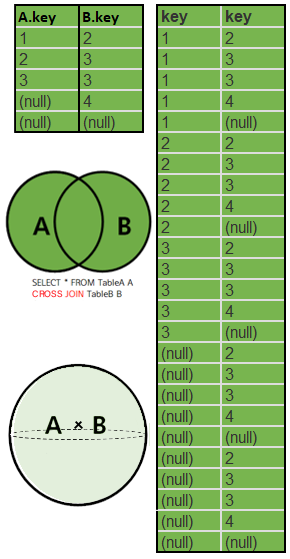

## Использование других операторов с джойнами

Перечислим клиентов, которые были в нашем отеле 1 января 2018 года:

    SELECT
        c.id,
        c.first_name,
        c.last_name
    FROM
        bookings b
        LEFT JOIN clients c ON c.id = b.renter_id
    WHERE
        b.check_in_date < '2018-01-02'
        AND b.check_out_date >= '2018-01-01'
        
Посмотрим, какую прибыль принес нам каждый день заезда (не платежа):

    SELECT
        DATE(b.check_in_date),
        SUM(p.amount_paid) as money
    FROM
        payments p
        JOIN bookings b ON p.booking_id = b.booking_id
    GROUP BY
        DATE(b.check_in_date)
	ORDER BY DATE(b.check_in_date)
    
## Джоин таблицы на саму себя

Сегодня у нас новогодний турнир по литрболу, и мы хотим составить перечень всех возможных пар участников. Кросс-джойн тут не подойдет, поскольку нам не нужны пары, где клиент играет сам с собой. Литрбол в одного - это алкоголизм, а мы против.

    WITH new_year_clients AS (
        SELECT
            c.id,
            c.first_name,
            c.last_name
        FROM
            bookings b
            LEFT JOIN clients c ON c.id = b.renter_id
        WHERE
            b.check_in_date < '2018-01-02'
            AND b.check_out_date >= '2018-01-01'
    )
    SELECT
        c1.id as id1,
        c1.first_name as first_name1,
        c1.last_name as last_name1,
        c2.id as id2,
        c2.first_name as first_name2,
        c2.last_name as last_name2
    FROM
        new_year_clients c1
        INNER JOIN new_year_clients c2
        ON c1.id <> c2.id

## UNION

Это вертикальное объединение таблиц.

Допустим, мы хотим выписать все важные даты января 2018. Под важными будем считать заезды, выезды и оплаты клиентов.

    (
        SELECT DATE(check_in_date) as important_date
        FROM bookings
        WHERE DATE(check_in_date) BETWEEN '2018-01-01' AND '2018-01-31'
    )
    UNION
    (
        SELECT DATE(check_out_date) as important_date
        FROM bookings
        WHERE DATE(check_out_date) BETWEEN '2018-01-01' AND '2018-01-31'
    )
    UNION
    (
        SELECT payment_date as important_date
        FROM payments
        WHERE payment_date BETWEEN '2018-01-01' AND '2018-01-31'
    )
    ORDER BY important_date

В этом запросе каждая дата встречается только один раз. Если нужно что-то другое, то можно использовать другие операторы работы с множествами:

- `UNION ALL` - Возвращаются все строки из обоих наборов.

- `UNION` - Возвращаются только уникальные строки двух наборов.

- `EXCEPT` - Возвращаются уникальные строки верхнего набора, которые отсутствуют в нижнем наборе.

- `INTERSECT` -	Возвращаются только уникальные строки, присутствующие в обоих наборах.

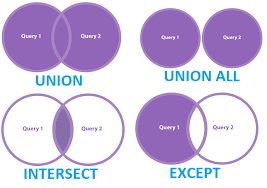

# Создание таблиц

Для создания таблицы в SQL используется команда `CREATE TABLE`, за которой следует имя новой таблицы и определение столбцов, включая их типы данных и, при необходимости, другие атрибуты (например, ограничения).

### Основной синтаксис

    CREATE TABLE имя_таблицы (
        имя_столбца1 тип_данных_столбца1 ограничения,
        имя_столбца2 тип_данных_столбца2 ограничения,
        ...
    );
    
Допустим, мы хотим создать таблицу students с информацией о студентах университета. Таблица должна содержать уникальный идентификатор студента (ID), его имя, возраст и специальность.


    CREATE TABLE students (
        id SERIAL PRIMARY KEY,
        name VARCHAR(100),
        age INT,
        field VARCHAR(100)
    );
В этом примере:

- `id` — это столбец с целочисленным типом данных, который автоматически увеличивает свое значение при добавлении новых строк (`SERIAL`) и который является первичным ключом (`PRIMARY KEY`) таблицы. Первичный ключ уникально идентифицирует каждую строку в таблице.
- `name` и `field` — это столбцы с текстовым типом данных (`VARCHAR`), где 100 указывает максимальную длину строки.
- `age` — ещё один столбец с целочисленным типом данных.


### Ограничения (Constraints)

В SQL можно (и даже зачастую нужно) также указывать различные ограничения для столбцов таблицы, чтобы обеспечить точность и надежность данных. Некоторые из наиболее часто используемых ограничений:

- `PRIMARY KEY` - указывает столбец как первичный ключ таблицы.
- `FOREIGN KEY` - устанавливает связь между столбцами в разных таблицах.
- `NOT NULL` - запрещает NULL (пустые) значения в столбце.
- `UNIQUE -` гарантирует, что все значения в столбце уникальны.
- `CHECK -` устанавливает диапазон допустимых значений для поля или столбца.
- `DEFAULT -` устанавливает значение по умолчанию для столбца, если значение не указано при вставке данных.

При создании таблицы можно комбинировать эти и другие ограничения, чтобы максимально точно описать структуру данных и правила их хранения.


## Добавление значений в таблицу

Для заполнения таблицы `students`, которую мы создали ранее, можно использовать команду `INSERT INTO`. Давайте добавим несколько записей в эту таблицу. Первичный ключ заполнится автоматически.

    INSERT INTO students (name, age, field)
    VALUES ('Александр', 19, 'Информатика');

    INSERT INTO students (name, age, field)
    VALUES ('Мария', 20, 'Математика');

    INSERT INTO students (name, age, field)
    VALUES ('Иван', 18, 'Физика');

Можно одним запросом добавить несколько записей:

    INSERT INTO students (name, age, field)
    VALUES 
    ('Елена', 21, 'Биология'),
    ('Николай', 22, 'Химия'),
    ('Ольга', 20, 'Литературоведение');
    
Посмотрим результат:

    SELECT * FROM students


## Изменение значений

    UPDATE students
    SET field = 'Компьютерные науки'
    WHERE id = 3

Посмотрим результат:

    SELECT * FROM students
    
## Удаление значений

    DELETE FROM students
    WHERE id = 3
    
Рекомендую никогда не забывать условие WHERE, иначе удалятся все записи из таблицы.

## Изменение состава колонок таблицы

Для любых изменений самого формата таблицы используется оператор `ALTER TABLE`. Добавим колонку email:

    ALTER TABLE students
    ADD COLUMN email VARCHAR(255)

У существующих строк новые значения заполняются `NULL`.

    SELECT * FROM students
    
Удалим колонку с возрастом студентов:

    ALTER TABLE students
    DROP COLUMN age;
    
- Удаление столбца является необратимой операцией, и потерянные данные восстановить будет нельзя.
- В некоторых системах управления базами данных (СУБД) операция удаления столбца может быть ограничена, если на столбец наложены определенные ограничения (например, внешние ключи).
- Перед выполнением таких операций рекомендуется сделать резервную копию данных, чтобы избежать случайной потери важной информации.
- Синтаксис может незначительно отличаться в разных СУБД, поэтому всегда полезно обратиться к документации конкретной СУБД, с которой вы работаете.

## Удаление данных из таблицы

Чтобы очистить таблицу, но не удалить ее саму, используется оператор `TRUNCATE`.

    TRUNCATE TABLE students
    
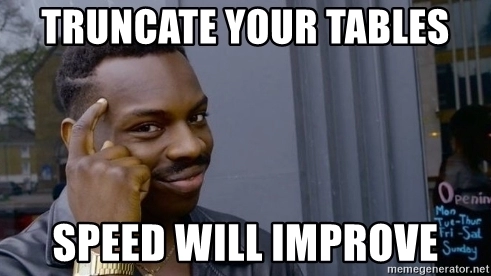

## Удаление таблицы полностью

А чтобы полностью удалить таблицу вместе с ее структурой, надо ее дропнуть:

    DROP TABLE students
    
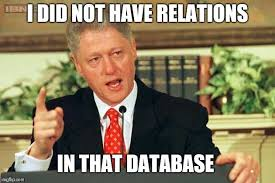

Операции удаления данных или удаления таблицы также могут блокироваться некоторыми ограничениями, заданными на таблицу.

# Представления

**Представления (views)** в SQL — это виртуальные таблицы, результаты запросов к одной или нескольким таблицам базы данных. Представления не хранят данные физически: вместо этого они сохраняют SQL запрос, который исполняется при обращении к представлению. Это позволяет абстрагироваться от сложных запросов, повторно использовать SQL код и упростить работу с данными для пользователя.

Основные особенности представлений:
- Безопасность данных. Представления могут ограничивать доступ к определенным столбцам или строкам таблицы, тем самым обеспечивая дополнительный уровень безопасности.

- Упрощение сложных запросов. Если вам часто приходится использовать сложные запросы с множеством соединений и подзапросов, представления позволяют скрыть эту сложность, предоставляя простой интерфейс для доступа к результатам таких запросов.

- Логическая структуризация. Представления могут использоваться для представления данных в более удобной или логической форме, что упрощает анализ и отчетность.

Создадим вьюху, которая хранит запрос для подсчета статистик по бронированиям.


    CREATE VIEW bookings_stats AS (
        (SELECT 'Количество бронирований' as stat_name, COUNT(*) as stat_value FROM bookings)
        UNION (SELECT 'Количество оплат' as stat_name, COUNT(*) as stat_value FROM payments)
        UNION (SELECT 'Количество оценок' as stat_name, COUNT(*) as stat_value FROM ratings)
        UNION (SELECT 'Количество клиентов' as stat_name, COUNT(*) as stat_value FROM clients)
    );
    
    SELECT * FROM bookings_stats


- Для обновления представления обычно используется команда CREATE OR REPLACE VIEW.
- Для удаления представления используется команда DROP VIEW.